# Synthetic experiments

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import optuna
import datetime

np.random.seed(0)
print(optuna.__version__)

3.6.0


## 0. Generating synthetic data

In [2]:
x = np.random.rand(10000, 4)
r0 = np.random.normal(0, 1, 10000)
r1 = 1 * x[:, 1] + 1 * x[:, 2] + np.random.normal(0, 1, 10000)

## 1. Evaluation policy $\pi_{e,1}$

In [3]:
def pi(x, pi_list, pi_prob):
    a_pi1 = np.array([np.random.rand(len(x)) < x[:, 0]])
    a_pi2 = np.array([x[:, 1] >= 0.5])
    a_pi3 = np.array([x[:, 2] >= 0.5])
    a = np.where(pi_list == 1, a_pi1, np.where(pi_list == 2, a_pi2, a_pi3))[0]
    w = x[:, 0] * pi_prob[0] + np.where(x[:, 1] >= 0.5, 1, 0) * pi_prob[1] + np.where(x[:, 2] >= 0.5, 1, 0) * pi_prob[2]
    return a, w


def calc_revenue(a, r0, r1):
    r = np.where(a, r1, r0)
    return r.mean()


def calc_eval(a, w, r0, r1, x, eval_policy):
    if eval_policy == 'ep1':
        ep_a = np.random.rand(len(x)) < x[:, 3]
        ep_w = x[:, 3]
    elif eval_policy == 'ep2':
        ep_a = np.random.rand(len(x)) < np.where(x[:, 1] >= 0.5, 0.8, 0.2)
        ep_w = np.where(x[:, 1] >= 0.5, 0.8, 0.2)
    ips_match = (ep_a == a)
    eval_r = np.where(a, r1, 0)[ips_match] * (ep_w[ips_match] / w[ips_match]) + np.where(a, r0, 0)[ips_match] * ((1 - ep_w[ips_match]) / (1 - w[ips_match]))
    truth_r = np.where(ep_a, r1, r0)[ips_match]
    return np.mean(np.square(eval_r - truth_r))


def object(trial):
    eval_policy = 'ep1'
    pi1_prob = trial.suggest_float('pi1_prob', 0.01, 1)
    pi2_prob = trial.suggest_float('pi2_prob', 0, 1-pi1_prob)
    pi3_prob = 1 - pi1_prob - pi2_prob
    pi_prob = [pi1_prob, pi2_prob, pi3_prob]
    pi_list = np.random.choice([1, 2, 3], size=len(x), p=pi_prob)
    a, w = pi(x, pi_list, pi_prob)
    rev_obj = calc_revenue(a, r0, r1)
    eval_obj =  calc_eval(a, w, r0, r1, x, eval_policy)
    return rev_obj, eval_obj


study = optuna.create_study(directions=['maximize', 'minimize'], sampler=optuna.samplers.NSGAIISampler(seed=0))
optuna.logging.disable_default_handler()
study.optimize(object, n_trials=1000)

[I 2024-05-17 15:48:52,953] A new study created in memory with name: no-name-42da27c0-37f7-4cd0-8f90-0ba38d0df9f1


In [4]:
optuna.visualization.plot_pareto_front(study, include_dominated_trials=False)

In [5]:
optuna.visualization.plot_slice(
    study,
    target=lambda t: t.values[0],
    target_name="Revenue performance",
).show()

In [6]:
optuna.visualization.plot_slice(
    study,
    target=lambda t: t.values[1],
    target_name="Mean squared error of off-policy evaluation",
).show()

In [7]:
df = study.trials_dataframe()

In [8]:
extract_col = ['number', 'params_pi1_prob', 'params_pi2_prob', 'values_0', 'values_1']
now = datetime.datetime.now()
now = now.strftime('%Y%m%d%H%M%S')
df[extract_col].to_csv('results/optuna_result_{}.csv'.format(now))

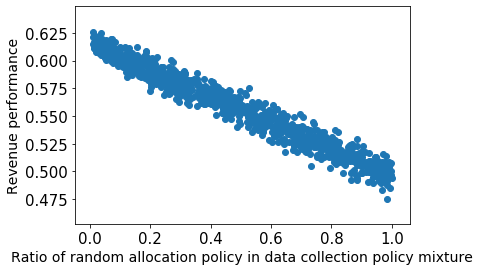

In [9]:
plt.scatter(df['params_pi1_prob'], df['values_0'])
plt.xlabel('Ratio of random allocation policy in data collection policy mixture', fontsize=14)
plt.ylabel('Revenue performance', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('results/revenue_synthetic_1.pdf', bbox_inches='tight')

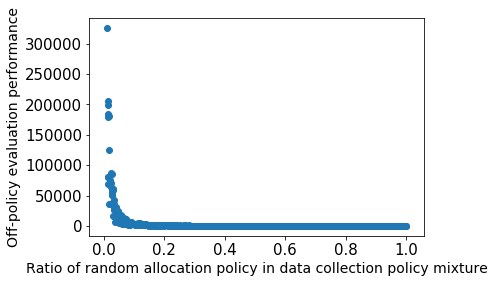

In [10]:
plt.scatter(df['params_pi1_prob'], df['values_1'])
plt.xlabel('Ratio of random allocation policy in data collection policy mixture', fontsize=14)
plt.ylabel('Off-policy evaluation performance', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('results/ope_synthetic_1.pdf', bbox_inches='tight')

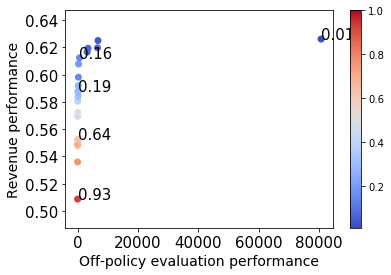

In [11]:
dominates = [False]*len(df)
values_0 = list(df['values_0'])
values_1 = list(df['values_1'])

for i in range(len(df)):
    for j in range(len(df)):
        if i == j:
            continue
        if dominates[j] == True:
            continue
        if values_0[j] >= values_0[i] and values_1[j] <= values_1[i]:
            dominates[i] = True
            break 
df['dominates'] = dominates
dom_df = df.query('dominates == False').copy()
dom_df.sort_values('values_0', inplace=True) 
dom_df.reset_index(drop=True, inplace=True)
plt.scatter(dom_df['values_1'], dom_df['values_0'], c=dom_df['params_pi1_prob'], cmap='coolwarm')
plt.clim(0.01, 1)
plt.colorbar()
plt.xlabel('Off-policy evaluation performance', fontsize=14)
plt.ylabel('Revenue performance', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
max_idx = 0
min_idx = len(dom_df) - 1 
q1_idx = len(dom_df) // 4 - 1
q2_idx = len(dom_df) // 2 - 1
q3_idx = len(dom_df) // 4 * 3 - 1
plt.text(dom_df['values_1'][max_idx] , dom_df['values_0'][max_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][max_idx]), fontsize=15)
plt.text(dom_df['values_1'][min_idx] , dom_df['values_0'][min_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][min_idx]), fontsize=15)
plt.text(dom_df['values_1'][q1_idx] , dom_df['values_0'][q1_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][q1_idx]), fontsize=15)
plt.text(dom_df['values_1'][q2_idx] , dom_df['values_0'][q2_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][q2_idx]), fontsize=15)
plt.text(dom_df['values_1'][q3_idx] , dom_df['values_0'][q3_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][q3_idx]), fontsize=15)
plt.savefig('results/curve_synthetic_1.pdf', bbox_inches='tight')

## 2. Evaluation policy $\pi_{e,2}$

In [12]:
def pi(x, pi_list, pi_prob):
    a_pi1 = np.array([np.random.rand(len(x)) < x[:, 0]])
    a_pi2 = np.array([x[:, 1] >= 0.5])
    a_pi3 = np.array([x[:, 2] >= 0.5])
    a = np.where(pi_list == 1, a_pi1, np.where(pi_list == 2, a_pi2, a_pi3))[0]
    w = x[:, 0] * pi_prob[0] + np.where(x[:, 1] >= 0.5, 1, 0) * pi_prob[1] + np.where(x[:, 2] >= 0.5, 1, 0) * pi_prob[2]
    return a, w


def calc_revenue(a, r0, r1):
    r = np.where(a, r1, r0)
    return r.mean()


def calc_eval(a, w, r0, r1, x, eval_policy):
    if eval_policy == 'ep1':
        ep_a = np.random.rand(len(x)) < x[:, 3]
        ep_w = x[:, 3]
    elif eval_policy == 'ep2':
        ep_a = np.random.rand(len(x)) < np.where(x[:, 1] >= 0.5, 0.8, 0.2)
        ep_w = np.where(x[:, 1] >= 0.5, 0.8, 0.2)
    ips_match = (ep_a == a)
    eval_r = np.where(a, r1, 0)[ips_match] * (ep_w[ips_match] / w[ips_match]) + np.where(a, r0, 0)[ips_match] * ((1 - ep_w[ips_match]) / (1 - w[ips_match]))
    truth_r = np.where(ep_a, r1, r0)[ips_match]
    return np.mean(np.square(eval_r - truth_r))


def object(trial):
    eval_policy = 'ep2'
    pi1_prob = trial.suggest_float('pi1_prob', 0.01, 1)
    pi2_prob = trial.suggest_float('pi2_prob', 0, 1-pi1_prob)
    pi3_prob = 1 - pi1_prob - pi2_prob
    pi_prob = [pi1_prob, pi2_prob, pi3_prob]
    pi_list = np.random.choice([1, 2, 3], size=len(x), p=pi_prob)
    a, w = pi(x, pi_list, pi_prob)
    rev_obj = calc_revenue(a, r0, r1)
    eval_obj =  calc_eval(a, w, r0, r1, x, eval_policy)
    return rev_obj, eval_obj


study = optuna.create_study(directions=['maximize', 'minimize'], sampler=optuna.samplers.NSGAIISampler(seed=0))
optuna.logging.disable_default_handler()
study.optimize(object, n_trials=1000)

In [13]:
optuna.visualization.plot_pareto_front(study, include_dominated_trials=False)

In [14]:
optuna.visualization.plot_slice(
    study,
    target=lambda t: t.values[0],
    target_name="Revenue performance",
).show()

In [15]:
optuna.visualization.plot_slice(
    study,
    target=lambda t: t.values[1],
    target_name="Mean squared error of off-policy evaluation",
).show()

In [16]:
df = study.trials_dataframe()

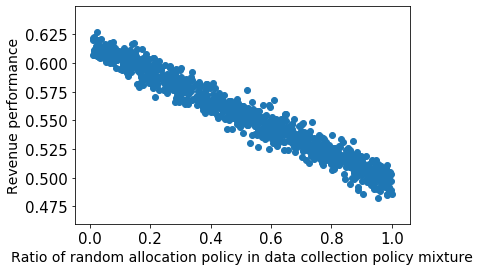

In [17]:
plt.scatter(df['params_pi1_prob'], df['values_0'])
plt.xlabel('Ratio of random allocation policy in data collection policy mixture', fontsize=14)
plt.ylabel('Revenue performance', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('results/revenue_synthetic_2.pdf', bbox_inches='tight')

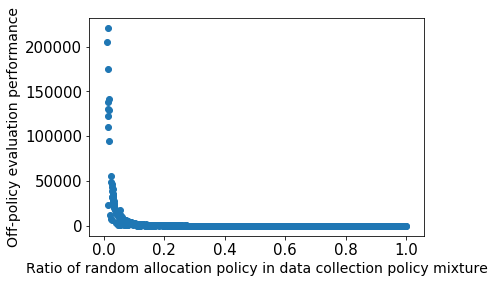

In [18]:
plt.scatter(df['params_pi1_prob'], df['values_1'])
plt.xlabel('Ratio of random allocation policy in data collection policy mixture', fontsize=14)
plt.ylabel('Off-policy evaluation performance', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('results/ope_synthetic_2.pdf', bbox_inches='tight')

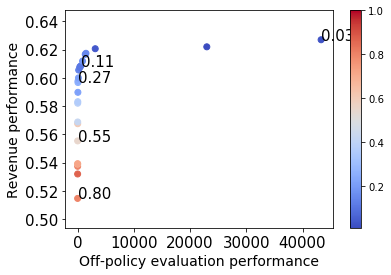

In [19]:
dominates = [False]*len(df)
values_0 = list(df['values_0'])
values_1 = list(df['values_1'])

for i in range(len(df)):
    for j in range(len(df)):
        if i == j:
            continue
        if dominates[j] == True:
            continue
        if values_0[j] >= values_0[i] and values_1[j] <= values_1[i]:
            dominates[i] = True
            break 
df['dominates'] = dominates
dom_df = df.query('dominates == False').copy()
dom_df.sort_values('values_0', inplace=True) 
dom_df.reset_index(drop=True, inplace=True)

plt.scatter(dom_df['values_1'], dom_df['values_0'], c=dom_df['params_pi1_prob'], cmap='coolwarm')
plt.clim(0.01, 1)
plt.colorbar()
plt.xlabel('Off-policy evaluation performance', fontsize=14)
plt.ylabel('Revenue performance', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
max_idx = 0
min_idx = len(dom_df) - 1 
q1_idx = len(dom_df) // 4 - 1
q2_idx = len(dom_df) // 2 - 1
q3_idx = len(dom_df) // 4 * 3 - 1
plt.text(dom_df['values_1'][max_idx] , dom_df['values_0'][max_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][max_idx]), fontsize=15)
plt.text(dom_df['values_1'][min_idx] , dom_df['values_0'][min_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][min_idx]), fontsize=15)
plt.text(dom_df['values_1'][q1_idx] , dom_df['values_0'][q1_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][q1_idx]), fontsize=15)
plt.text(dom_df['values_1'][q2_idx] , dom_df['values_0'][q2_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][q2_idx]), fontsize=15)
plt.text(dom_df['values_1'][q3_idx] , dom_df['values_0'][q3_idx], '{:.2f}'.format(dom_df['params_pi1_prob'][q3_idx]), fontsize=15)
plt.savefig('results/curve_synthetic_2.pdf', bbox_inches='tight')